# Импорты

In [2]:
import sys
import os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !pip install -q gymnasium
    !pip install moviepy
    !apt install ffmpeg
    !pip install imageio-ffmpeg
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [3]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [4]:
!pip install swig
!pip install "gymnasium[box2d]"

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive
%cd MyDrive

/content/drive
/content/drive/MyDrive


Адрес вашей рабочей директории:

# BiPedal Walker

### Осваиваемся в среде

**Ссылки:**
* https://gymnasium.farama.org/environments/box2d/bipedal_walker/
* https://github.com/openai/gym/wiki/BipedalWalker-v2

**Цель:** Набрать 300 очков за 1600 шагов
* Двигаться быстро
* Не падать
* Расходовать меньше энергии

**Награды:**
* За движение вперёд начисляются очки (300 максимум)
* Падение: -100 очков.
* Применение крутящего момента двигателя стоит небольшого количества очков.  

**Действия:**

Скорости на 4 моторах:
* На каждом колене и бедре
* Каждая в диапазоне [-1, 1]

**Пространство состояний:**

<img src="https://i.ibb.co/yn5xDr3k/2.png" alt="2" border="0" width="300">


**Начальное состояние:**
* Робот стоит в левом конце местности
* Корпус горизонтальный
* Обе ноги в одном положении с небольшим углом колена.  

**Завершение эпизода:**
Эпизод заканчивается, если корпус касается земли или если робот выходит за правый конец местности.

In [6]:
import gymnasium as gym
env = gym.make('BipedalWalker-v3', hardcore=False, render_mode='rgb_array')

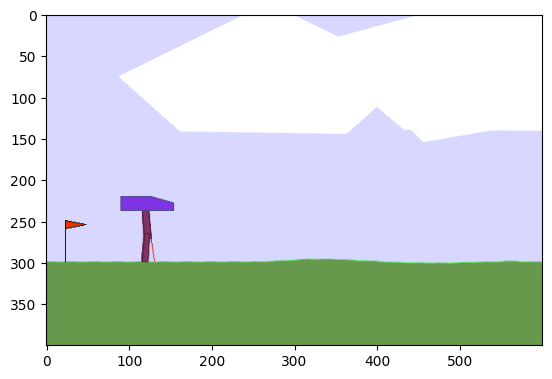

In [7]:
action = env.reset()
render = env.render()
plt.imshow(render)

(`Новое место`, `Награда`, `Закончили?`, `Время вышло?`, {**prob:** `Вероятность перехода` (всегда `1`)})

 * `new_observation`: an observation right after committing the action `a`
 * `reward`: a number representing your reward for committing action `a`
 * `terminated`: True if the MDP has just finished, False if still in progress
 * `truncated`: True if the number of steps elapsed >= max episode steps
 * `info`: some auxiliary stuff about what just happened. For now, ignore it.

### Пробуем

In [ ]:
action_size = env.action_space.shape[0]
for episode in range(10):
    env.reset()
    while True:
        action = np.random.uniform(-1.0, 1.0, size=action_size)
        next_state, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break

### Architecture

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
STATE_DIM = 24
ACTIONS_N = 4


class Actor(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.hidden = nn.Linear(STATE_DIM, hidden_dim)
        self.mean = nn.Linear(hidden_dim, ACTIONS_N)
        self.logstd = nn.Parameter(torch.zeros(ACTIONS_N))

    def forward(self, state):
        state_embed = self.hidden(state)
        outs = F.relu(state_embed)
        means = self.mean(outs)
        stds = self.logstd.exp()
        return means, stds


class Critic(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(STATE_DIM, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        out = self.main(state)
        value = self.main(state)[:, 0]
        return value

In [9]:
gamma = 0.99 # discount

def pick_sample_and_logp(state, actor_model):
  with torch.no_grad():
    state_tensor = torch.tensor(state, dtype=torch.float).to(device)
    means, stds = actor_model(state_tensor)

    # В непрерывных средах важно предсказывать нормальное распределение
    # Из-за принципа работы некоторых состояний от [-1, 1]
    # Какие тут могут быть подводные камни? Если у нас есть другое пространство, допустим дрон и препятсвия
    # может быть так, что будет несколько кууполов с распределением, что не сильно будет упрощать работу
    distribution = torch.distributions.Normal(means, stds)
    action = distribution.sample().tolist()
    action_tensor = torch.tensor(action, dtype=torch.float).to(device)
    action_tensor = torch.clamp(action_tensor, min=-1, max=1)
    log_prob = distribution.log_prob(action_tensor).sum(-1)
    entropy = distribution.entropy().sum(-1)
    # print(f"{action=}")
    # print(f"{action_tensor=}")
    # print(f"{means=}")
    # print(f"{stds=}")
    # print(f"{log_prob=}")
    # print(f"{entropy=}")
    return action_tensor, means, stds, log_prob, entropy

# Обучение

In [10]:
actor_model = Actor().to(device)
critic_model = Critic().to(device)

NameError: name 'Actor' is not defined

In [11]:
gamma = 0.99
kl_coeff = 0.20  # weight coefficient, KL-divergence loss
vf_coeff = 0.50  # weight coefficient, value loss
episodes_n = 2
env = gym.make('BipedalWalker-v3', hardcore=False, render_mode='rgb_array')
reward_records = []
all_params = list(actor_model.parameters()) + list(critic_model.parameters())
opt = torch.optim.AdamW(all_params, lr=0.0005)

for i in range(episodes_n):
  done = False
  states = []
  actions = []
  means = []
  stds = []
  rewards = []
  log_probs = []
  ents = []
  s, _ = env.reset()
  while not done:
    states.append(s.tolist())
    action, mean, std, log_prob, entropy = pick_sample_and_logp(s, actor_model)
    s, r, term, trunc, _ = env.step(action)
    done = term or trunc
    actions.append(action)
    means.append(sum(mean))
    log_probs.append(sum(log_prob))
    stds.append(std)
    ents.append(entropy)
    rewards.append(r)

  # Вычисляем куммулятивную награду
  cum_rewards = np.zeros_like(rewards)
  reward_len = len(rewards)
  print(f"{reward_len=}")
  for j in reversed(range(reward_len)):
      cum_rewards[j] = rewards[j] + (cum_rewards[j + 1] * gamma if j + 1 < reward_len else 0)

  # Обучение
  opt.zero_grad()

  states = torch.tensor(states, dtype=torch.float).to(device)
  # actions = torch.tensor(actions, dtype=torch.float).to(device)
  means_old = torch.tensor(means, dtype=torch.float).to(device)
  log_probs_old = torch.tensor(log_probs_old, dtype=torch.float).to(device)

  log_probs_old = log_probs.unsqueeze(dim=1)
  cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)
  cum_rewards = cum_rewards.unsqueeze(dim=1)

  # Считаем V-функцию с новыми параметрами
  values_new = critic_model(states)
  mean_new, std_new = actor_model(states)

  # Вычисляем Advantage-функцию
  advantages = cum_rewards - values_new

  # Вычисляем пропорцию P_new / P_old
  logprobs_new = -F.cross_entropy(mean_new, mean_old, reduction="none")
  logprobs_new = logprob_new.unsqueeze(dim=1)
  prob_ratio = torch.exp(log_prob_new - log_prob)

  # Calculate KL-div for Categorical distribution
  l0 = means_old - torch.amax(means_old, dim=1, keepdim=True)
  l1 = logits_new - torch.amax(logits_new, dim=1, keepdim=True)
  e0 = torch.exp(l0)
  e1 = torch.exp(l1)
  e_sum0 = torch.sum(e0, dim=1, keepdim=True)
  e_sum1 = torch.sum(e1, dim=1, keepdim=True)
  p0 = e0 / e_sum0
  kl = torch.sum(
      p0 * (l0 - torch.log(e_sum0) - l1 + torch.log(e_sum1)),
      dim=1,
      keepdim=True)

  # Вычисляем value loss
  vf_loss = F.mse_loss(
      values_new,
      cum_rewards,
      reduction="none")

  # Вычисляем total loss
  loss = -advantages * prob_ratio + kl * kl_coeff + vf_loss * vf_coeff

  # Шаг оптимизатора
  loss.sum().backward()
  opt.step()

  # Сохраняем суммарную награду
  print("Run episode {} with rewards {}".format(i, np.sum(rewards)), end="\r")
  reward_records.append(np.sum(rewards))

print("\nDone")
env.close()

NameError: name 'actor_model' is not defined

In [12]:
gamma = 0.99
kl_coeff = 0.20  # weight coefficient, KL-divergence loss
vf_coeff = 0.50  # weight coefficient, value loss
episodes_n = 2
env = gym.make('BipedalWalker-v3', hardcore=False, render_mode='rgb_array')
reward_records = []
all_params = list(actor_model.parameters()) + list(critic_model.parameters())
opt = torch.optim.AdamW(all_params, lr=0.0005)

for i in range(episodes_n):
  done = False
  states = []
  actions = []
  means = []
  stds = []
  rewards = []
  log_probs = []
  ents = []
  s, _ = env.reset()
  while not done:
    states.append(s.tolist())
    action, mean, std, log_prob, entropy = pick_sample_and_logp(s, actor_model)
    s, r, term, trunc, _ = env.step(action)
    done = term or trunc
    actions.append(action)
    means.append(sum(mean))
    log_probs.append(sum(log_prob))
    stds.append(std)
    ents.append(entropy)
    rewards.append(r)

  # Вычисляем куммулятивную награду
  cum_rewards = np.zeros_like(rewards)
  reward_len = len(rewards)
  print(f"{reward_len=}")
  for j in reversed(range(reward_len)):
      cum_rewards[j] = rewards[j] + (cum_rewards[j + 1] * gamma if j + 1 < reward_len else 0)

  # Обучение
  opt.zero_grad()

  states = torch.tensor(states, dtype=torch.float).to(device)
  # actions = torch.tensor(actions, dtype=torch.float).to(device)
  means_old = torch.tensor(means, dtype=torch.float).to(device)
  log_probs_old = torch.tensor(log_probs_old, dtype=torch.float).to(device)

  log_probs_old = log_probs.unsqueeze(dim=1)
  cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)
  cum_rewards = cum_rewards.unsqueeze(dim=1)

  # Считаем V-функцию с новыми параметрами
  values_new = critic_model(states)
  mean_new, std_new = actor_model(states)

  # Вычисляем Advantage-функцию
  advantages = cum_rewards - values_new

  # Вычисляем пропорцию P_new / P_old
  logprobs_new = -F.cross_entropy(mean_new, means_old, reduction="none")
  logprobs_new = logprobs_new.unsqueeze(dim=1)
  prob_ratio = torch.exp(logprobs_new - log_prob)

  # Calculate KL-div for Categorical distribution
  l0 = means_old - torch.amax(means_old, dim=1, keepdim=True)
  l1 = logprobs_new - torch.amax(logprobs_new, dim=1, keepdim=True)
  e0 = torch.exp(l0)
  e1 = torch.exp(l1)
  e_sum0 = torch.sum(e0, dim=1, keepdim=True)
  e_sum1 = torch.sum(e1, dim=1, keepdim=True)
  p0 = e0 / e_sum0
  kl = torch.sum(
      p0 * (l0 - torch.log(e_sum0) - l1 + torch.log(e_sum1)),
      dim=1,
      keepdim=True)

  # Вычисляем value loss
  vf_loss = F.mse_loss(
      values_new,
      cum_rewards,
      reduction="none")

  # Вычисляем total loss
  loss = -advantages * prob_ratio + kl * kl_coeff + vf_loss * vf_coeff

  # Шаг оптимизатора
  loss.sum().backward()
  opt.step()

  # Сохраняем суммарную награду
  print("Run episode {} with rewards {}".format(i, np.sum(rewards)), end="\r")
  reward_records.append(np.sum(rewards))

print("\nDone")
env.close()

NameError: name 'actor_model' is not defined

## Готовая реализация

In [13]:
!pip install stable_baselines3

In [14]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.logger import configure
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback

import numpy as np
from tqdm import tqdm

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [15]:
log_dir = "./logs"

In [16]:
%mkdir ./logs

In [17]:
a = np.arange(10, 11, 10)
print(a)

[10]


In [18]:
base_path = log_dir
for steps in np.arange(50000, 100001, 50000):
    max_episode_steps = 500
    vec_env = make_vec_env('BipedalWalker-v3', n_envs=1, env_kwargs={'max_episode_steps': max_episode_steps})
    tmp_path = base_path + str(steps) + "/"
    new_logger = configure(tmp_path, ["tensorboard", "csv"])
    model = PPO("MlpPolicy", vec_env, verbose=0)
    model.set_logger(new_logger)
    model.learn(total_timesteps=steps, progress_bar=True)

KeyboardInterrupt: 

In [ ]:
env = Monitor(env, log_dir)

In [ ]:
base_path = log_dir
for steps in np.arange(40000, 80001, 40000):
    max_episode_steps = 500
    vec_env = make_vec_env('BipedalWalker-v3', n_envs=1, env_kwargs={'max_episode_steps': max_episode_steps})
    tmp_path = base_path + str(steps) + "/"
    new_logger = configure(tmp_path, ["tensorboard", "csv"])
    model_ppo = PPO("MlpPolicy", vec_env, verbose=0)
    model_ppo.set_logger(new_logger)
    callback = EvalCallback(env)
    model_ppo.learn(total_timesteps=steps, progress_bar=True, callback=callback)

Output()

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

New best mean reward!

Eval num_timesteps=20000, episode_reward=-42.15 +/- 0.23

Episode length: 1600.00 +/- 0.00

New best mean reward!

Eval num_timesteps=30000, episode_reward=-67.20 +/- 0.15

Episode length: 1600.00 +/- 0.00

Eval num_timesteps=40000, episode_reward=-69.76 +/- 4.77

Output()

Eval num_timesteps=10000, episode_reward=-93.41 +/- 0.15

Episode length: 133.00 +/- 4.60

New best mean reward!

Eval num_timesteps=20000, episode_reward=-54.66 +/- 40.95

Episode length: 1021.20 +/- 708.91

New best mean reward!

Eval num_timesteps=30000, episode_reward=-40.23 +/- 0.15

Episode length: 1600.00 +/- 0.00

New best mean reward!

Eval num_timesteps=40000, episode_reward=-56.14 +/- 2.42

Episode length: 1600.00 +/- 0.00

Eval num_timesteps=50000, episode_reward=-65.89 +/- 0.34

Episode length: 1600.00 +/- 0.00

Eval num_timesteps=60000, episode_reward=-71.38 +/- 3.52

Episode length: 1600.00 +/- 0.00

Eval num_timesteps=70000, episode_reward=-93.82 +/- 29.59

Episode length: 1035.60 +/- 691.32

Eval num_timesteps=80000, episode_reward=-37.91 +/- 5.56

Episode length: 1600.00 +/- 0.00

New best mean reward!

In [ ]:
from stable_baselines3.common import results_plotter
%matplotlib inline

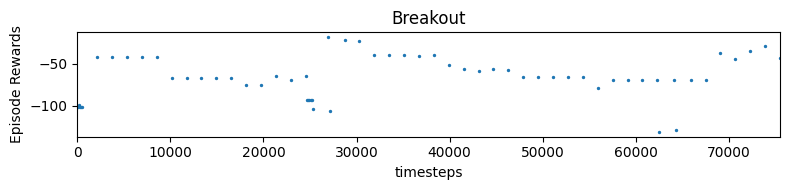

In [ ]:
results_plotter.plot_results([log_dir], 10e6, results_plotter.X_TIMESTEPS, "Breakout")

In [ ]:
%ls logs50000

events.out.tfevents.1746442595.110e320d4224.199.0  progress.csv


In [ ]:
x, y = results_plotter.ts2xy(results_plotter.load_results(log_dir), "timesteps")

Text(0, 0.5, 'Rewards')

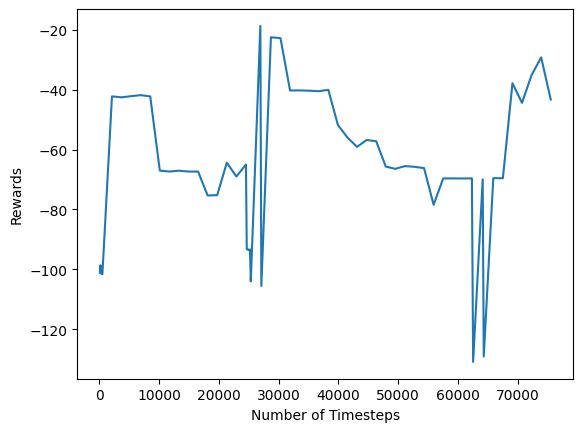

In [ ]:
plt.plot(x, y)
plt.xlabel("Number of Timesteps")
plt.ylabel("Rewards")

In [ ]:
%ls logs40000/

events.out.tfevents.1746444128.110e320d4224.199.2
events.out.tfevents.1746444174.110e320d4224.199.3
events.out.tfevents.1746444182.110e320d4224.199.4
events.out.tfevents.1746444189.110e320d4224.199.5
events.out.tfevents.1746444208.110e320d4224.199.6
progress.csv


### Запись видео

In [ ]:
def do_episode(env, actor):
  state, _ = env.reset()
  done = False
  truncated = False

  while not (done or truncated):
    action, mean, std, log_prob, entropy = pick_sample_and_logp(state, actor)
    state, _, done, truncated, info = env.step(action)

In [ ]:
from gymnasium.wrappers import RecordVideo

with gym.make("BipedalWalker-v3", render_mode="rgb_array") as env, RecordVideo(
    env=env, video_folder="./videos"
) as env_monitor:
    do_episode(env_monitor, actor_model)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/Classroom 2024-2025/Otus/C-RL/02-06 (DDPG -> TD3 -> LSTM-TD3)/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/box2d/bipedal_walker.py:535: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  self.joints[0].motorSpeed = float(SPEED_HIP * np.sign(action[0]))
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned 

In [ ]:
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
import sys

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))